In [1]:
import torch
from models.stylegan_generator import *
from models.stylegan_discriminator import *
from models import *
import matplotlib.pyplot as plt
import numpy as np
from misc import *
from tqdm import tqdm
from PIL import Image
import matplotlib
from VGG16_pre import *
from matplotlib import gridspec

import torch.nn as nn

In [2]:
#take pretrained StyleGAN model form genforce git.
Gs_style = StyleGANGenerator(resolution = 1024)
D_style = StyleGANDiscriminator(resolution = 1024)

#you should change the name of .pth for your code.
model = torch.load('stylegan_celebahq1024.pth')
model.keys()

dict_keys(['generator', 'discriminator', 'generator_smooth'])

In [3]:
#load the models and cuda.
Gs_style.load_state_dict(model['generator_smooth'])
D_style.load_state_dict(model['discriminator'])


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

Gs_style.eval().to(device)
D_style.eval().to(device)

StyleGANDiscriminator(
  (input0): ConvBlock(
    (mbstd): Identity()
    (blur): Identity()
    (downsample): Identity()
    (activate): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer0): ConvBlock(
    (mbstd): Identity()
    (blur): Identity()
    (downsample): Identity()
    (activate): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer1): ConvBlock(
    (mbstd): Identity()
    (blur): BlurLayer()
    (downsample): Identity()
    (activate): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (input1): ConvBlock(
    (mbstd): Identity()
    (blur): Identity()
    (downsample): Identity()
    (activate): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer2): ConvBlock(
    (mbstd): Identity()
    (blur): Identity()
    (downsample): Identity()
    (activate): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer3): ConvBlock(
    (mbstd): Identity()
    (blur): BlurLayer()
    (downsample): Identity()
    (activate): LeakyReLU(negative_slope=0.2, inplace=True)
 

In [4]:
if 0:
    features_4x4 = d_outputs(D_style, name = 'layer16')
    np.save('./features_4x4.npy', features_4x4)

In [5]:
find_4x4 = find_data_any(Gs_style, D_style, query, indice, real_features = 'features_4x4.npy', output_layer = 'layer16', random = False)

features_4x4.shape :  (30000, 8192)
gen_image.shape :  (1, 3, 1024, 1024)


gen_image.shape :  (1, 3, 1024, 1024)
indice :  [19443 17859 23177 12179   736 21548  7779 11554 24847  7218 27333   885
 24431]


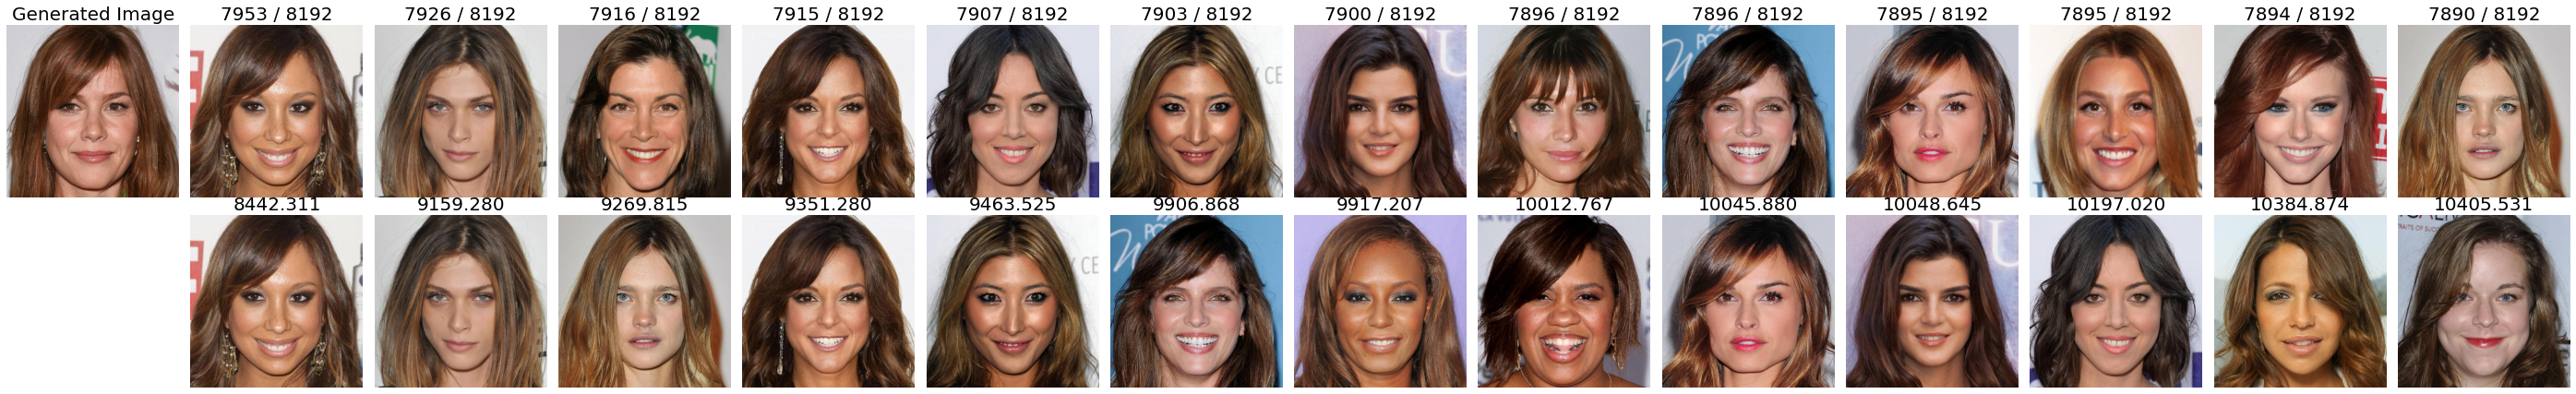

In [6]:
find_4x4.generate_image()
indice, indice_dist = find_4x4(13, dist = True)

In [7]:
# select one of similar real images
real_image = Image.open('../GANCP/celebA_analysis/data1024x1024/{:5d}.jpg'.format(indice[0])).convert("RGB")
real_image_np = np.array(real_image)
real_image_np.shape

(1024, 1024, 3)

In [8]:
class optimizer(nn.Module):
    def __init__(self, ):
        super(optimizer, self).__init__()
                
        self.module = nn.Sequential(*(list(Gs_style.children())[2:]))
        self.add_module('generator', self.module)
        
#         print(self.generator)
#         for param in self.module.parameters():
#             param.requires_grad = False
            
    def forward(self, x):
        out = self.generator(x)
        return out

In [9]:
latent = query[find_4x4.index]
out = Gs_style(torch.Tensor([latent]).to(device))
input_w = out['w'].detach().clone()
print('input_w.size() : ',input_w.size())

input_w.size() :  torch.Size([1, 512])


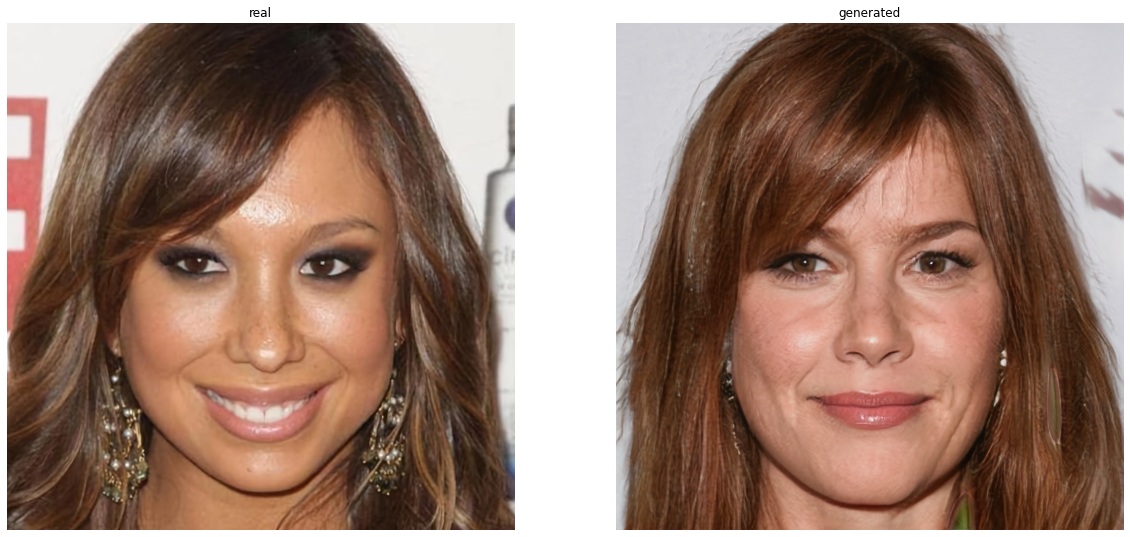

In [10]:
fig = plt.figure(figsize = (20,40))
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('real')
plt.axis('off')
ax1.imshow(real_image_np)

ax2 = fig.add_subplot(1,2,2)
img = out['image'].detach().cpu().numpy()[0]
ax2.set_title('generated')
img = adjust_dynamic_range(img, [img.min(), img.max()], [0,1])
ax2.imshow(img.transpose(1,2,0))
plt.axis('off')
plt.show()

In [11]:
input_w = input_w.to(device).requires_grad_(True)
optim_vector = optimizer()
optim = torch.optim.Adam([input_w], lr = 0.01, betas=(0.9, 0.999), eps = 1e-8)
criterion = torch.nn.MSELoss(reduction = "mean")

vgg_16 = VGG16_perceptual().to(device)
upsample = nn.Upsample(scale_factor = 256/1024, mode = 'bilinear')

images = []

real_image_np = (real_image_np - real_image_np.min())/(real_image_np.max() - real_image_np.min())

############################# Hook ##############################
feature_map = {}

def save_features(name):
    def fn(_, __, out):
#         print(out)
        if name not in feature_map:
            feature_map[name] = [out[0].detach().cpu().numpy()]
        else:
            feature_map[name].append(out[0].detach().cpu().numpy())
    return fn

optim_vector.module[0].layer5.register_forward_hook(save_features('layer5'))
# optim_vector.module[0].layer7.register_forward_hook(save_features('layer7'))
# optim_vector.module[0].layer9.register_forward_hook(save_features('layer9'))
# optim_vector.module[0].layer11.register_forward_hook(save_features('layer11'))
# optim_vector.module[0].layer13.register_forward_hook(save_features('layer13'))
# optim_vector.module[0].layer15.register_forward_hook(save_features('layer15'))

###################################################################

for i in range(1000):
    input_w18 = input_w.unsqueeze(1).expand(-1,18,512)
    output = optim_vector(input_w18)
    gen_image = output['image']
    
    gen_image = (gen_image - gen_image.min())/(gen_image.max() - gen_image.min())
    
    mse, per_loss = loss_fn(gen_image, torch.Tensor(real_image_np).to(device), criterion, upsample, vgg_16)
    
    loss = mse + per_loss
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    
    
    if i % 2 == 0:
#         plt.figure(figsize = (4,4))
        img = gen_image.detach().cpu().numpy().copy()
        img = adjust_dynamic_range(img, [img.min(), img.max()], [0,1])
#         print(type(img))
        images.append(img[0].transpose(1,2,0))
#         print(loss)
#         plt.imshow(img[0].transpose(1,2,0))
#         plt.axis('off')
#         plt.show()


input_w1 = input_w.unsqueeze(1).expand(-1, 18, 512)
input_w1 = input_w1.clone().detach().requires_grad_(True)
optim = torch.optim.Adam([input_w1], lr = 0.01, betas = (0.9, 0.999), eps = 1e-8)

for i in range(1000):
    output = optim_vector(input_w1)
    gen_image = output['image']
    
    gen_image = (gen_image - gen_image.min())/(gen_image.max() - gen_image.min())
    
    mse, per_loss = loss_fn(gen_image, torch.Tensor(real_image_np).to(device), criterion, upsample, vgg_16)
    
    loss = mse + per_loss
    
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    if i % 2 == 0:
#         plt.figure(figsize = (4,4))
        img = gen_image.detach().cpu().numpy().copy()
        img = adjust_dynamic_range(img, [img.min(), img.max()], [0,1])
#         print(type(img))
        images.append(img[0].transpose(1,2,0))
    
#     if i % 10 == 0:
#         plt.figure(figsize = (4,4))
#         img = gen_image.detach().cpu().numpy().copy()
#         img = adjust_dynamic_range(img, [img.min(), img.max()], [0,1])

#         print(loss)
#         plt.imshow(img[0].transpose(1,2,0))
#         plt.axis('off')
#         plt.show()

/home/hwanil/anaconda3/envs/pggan/lib/python3.6/site-packages/torch/nn/functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [18]:
feature_map.keys()

KeyError: 'lyaer15'

In [19]:
for key in feature_map.keys():
    print(f'{key}.shape = ', np.array(feature_map[key]).shape)

layer5.shape =  (2000, 1, 512, 16, 16)


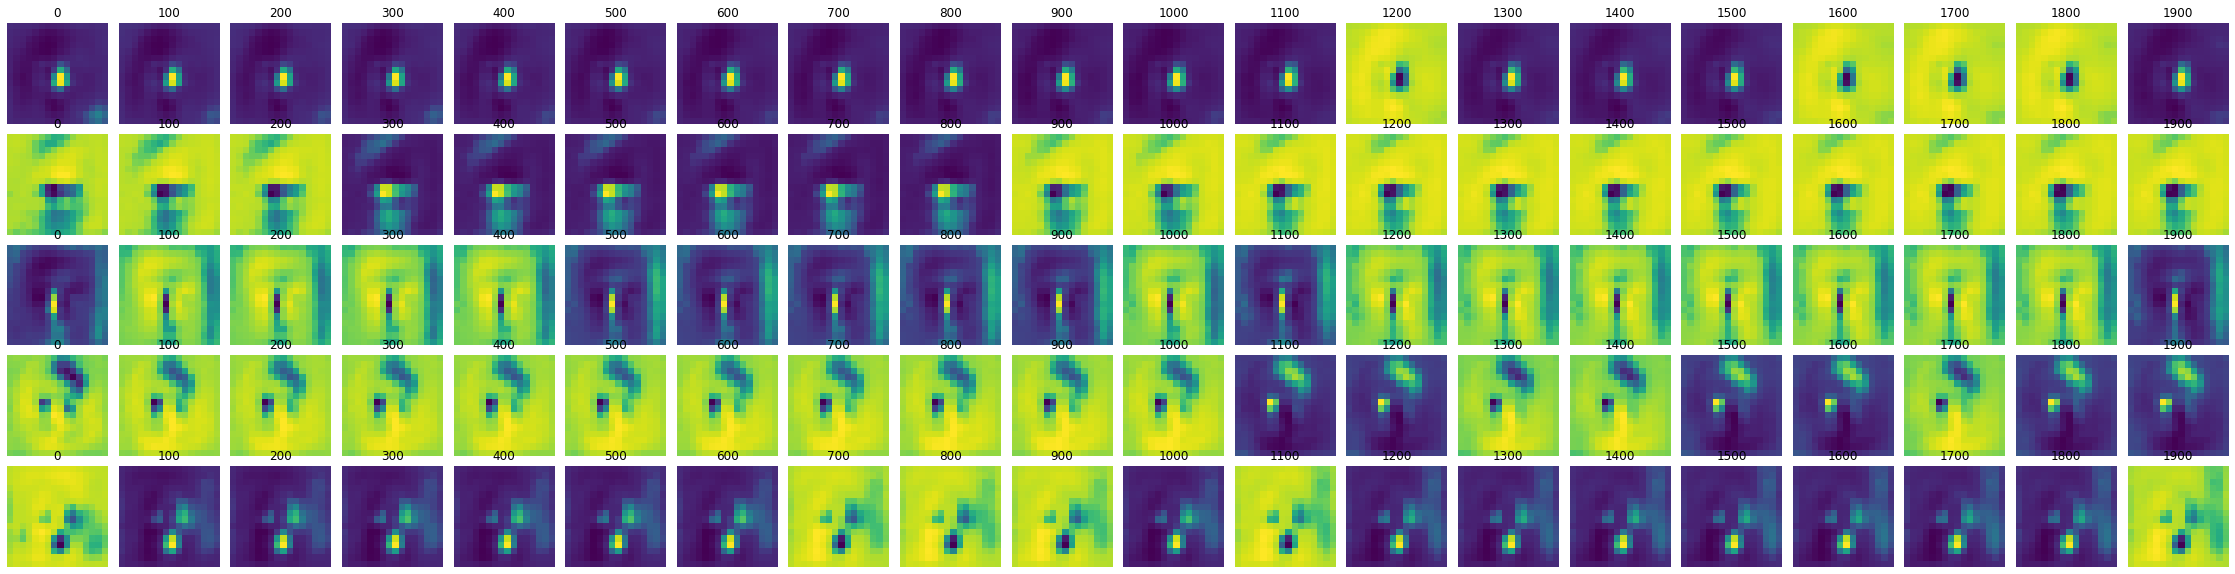

In [16]:
dist = dist_neighbor(feature_map['layer5'])

dist = np.array(dist)
sorted_dist = np.argsort(dist)
show_features(feature_map['layer5'], sorted_dist[-5:], 20, show_index = True)

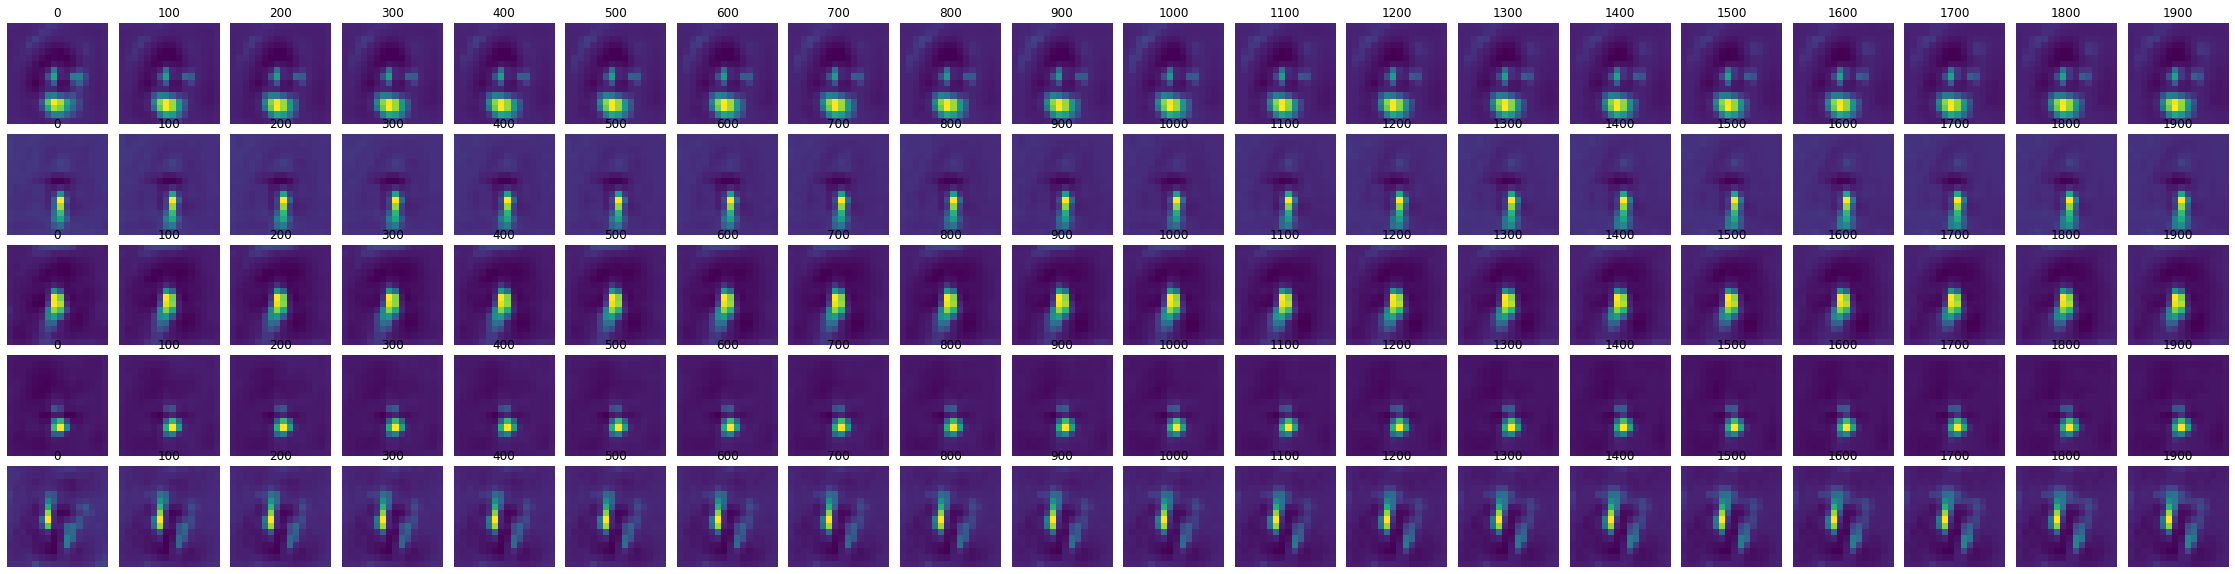

In [17]:
show_features(feature_map['layer5'], sorted_dist[:5], 20, show_index = True)

Text(0.5, 1.0, 'real')

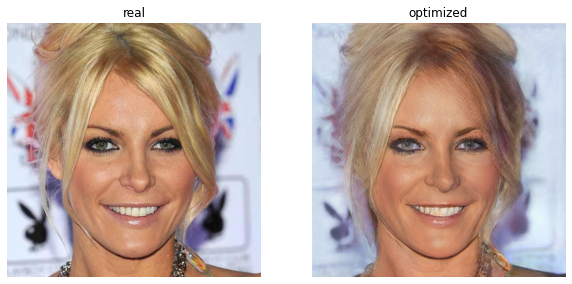

In [18]:
i = nn.Sequential(*list(Gs_style.children())[2:]).to(device)(input_w1)
i = (i['image'] - i['image'].min())/(i['image'].max() - i['image'].min())

# plt.figure(figsize=(100,100))
fig, ax = plt.subplots(1,2, figsize = (10,20))
ax[1].imshow(i[0].detach().cpu().numpy().transpose(1,2,0))
ax[1].axis('off')
ax[1].set_title('optimized')
ax[0].imshow(real_image_np)
ax[0].axis('off')
ax[0].set_title('real')
# plt.imshow(i[0].detach().cpu().numpy().transpose(1,2,0))

In [19]:
optimized_data = find_data_any(optim_vector, D_style, np.array([input_w1[0].detach().cpu().numpy()]), np.array([0]),
                   real_images = '../GANCP/celebA_analysis/data1024x1024/', 
                   real_features = './features_4x4.npy',  
                   output_layer = 'layer16', random = True)

features_4x4.shape :  (30000, 8192)
gen_image.shape :  (1, 3, 1024, 1024)
(1, 8192)
(30000, 8192)


In [20]:
optimized_data.generate_image(0)

gen_image.shape :  (1, 3, 1024, 1024)
(1, 8192)
(30000, 8192)


indice :  [11395 29720 18832 20883  2951  5570  9423 26159  4997 17649 29898  4232
 23472]


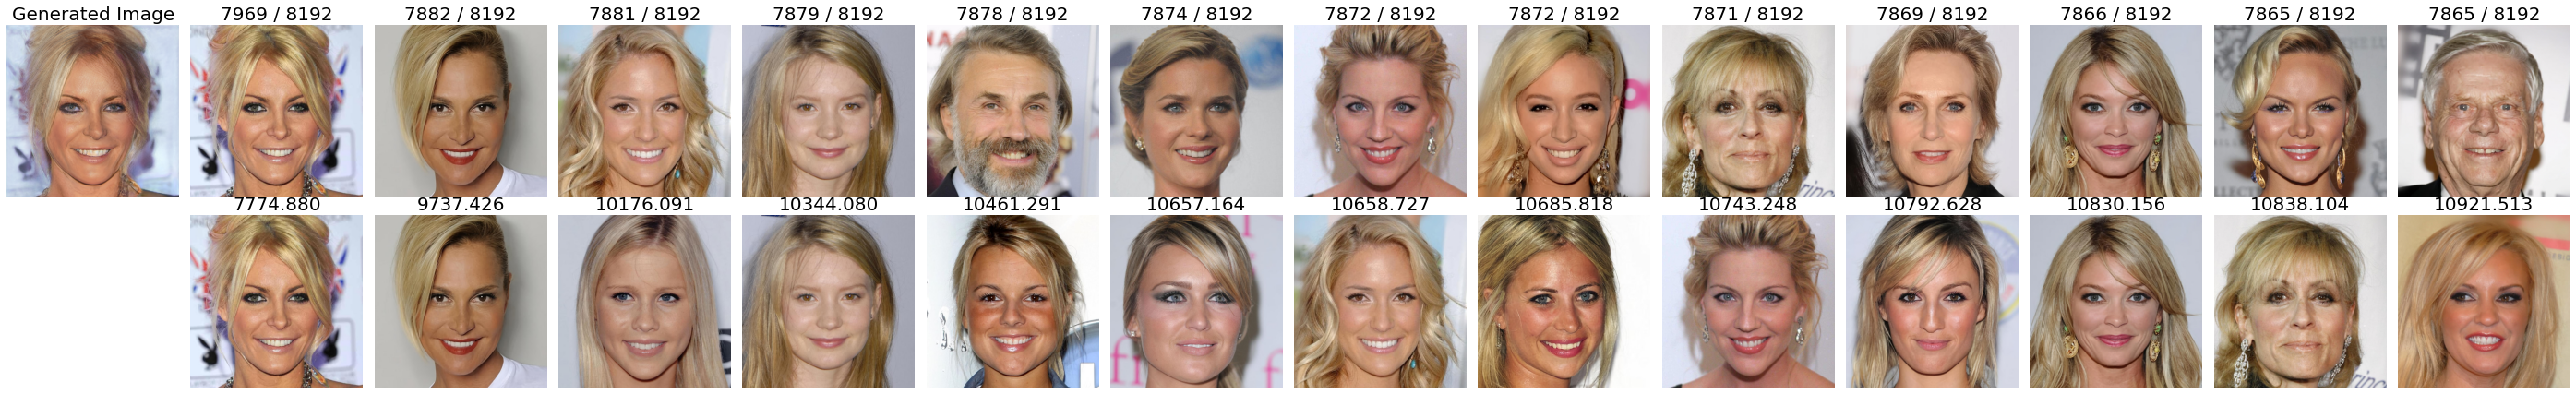

(array([11395, 29720, 18832, 20883,  2951,  5570,  9423, 26159,  4997,
        17649, 29898,  4232, 23472]),
 array([11395, 29720,  7319, 20883, 11731,  1901, 18832, 28215,  9423,
        19460, 29898,  4997, 16692]))

In [21]:
optimized_data(13,dist = True)